# What is RAG?

RAG is a technique for augmenting LLM knowledge with additional data.

LLMs can reason about wide-ranging topics, but their knowledge is limited to the public data up to a specific point in time that they were trained on. If you want to build AI applications that can reason about private data or data introduced after a model's cutoff date, you need to augment the knowledge of the model with the specific information it needs. The process of bringing the appropriate information and inserting it into the model prompt is known as Retrieval Augmented Generation (RAG).

# Concepts

A typical RAG application has two main components:

**Indexing**: a pipeline for ingesting data from a source and indexing it. This usually happens offline.

**Retrieval and generation**: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.



The most common full sequence from raw data to answer looks like:

## Indexing

1. Load: First we need to load our data. This is done with DocumentLoaders.
2. Split: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won't fit in a model's finite context window.
3. Store: We need somewhere to store and index our splits, so that they can later be searched over. This is often done using a VectorStore and Embeddings model.

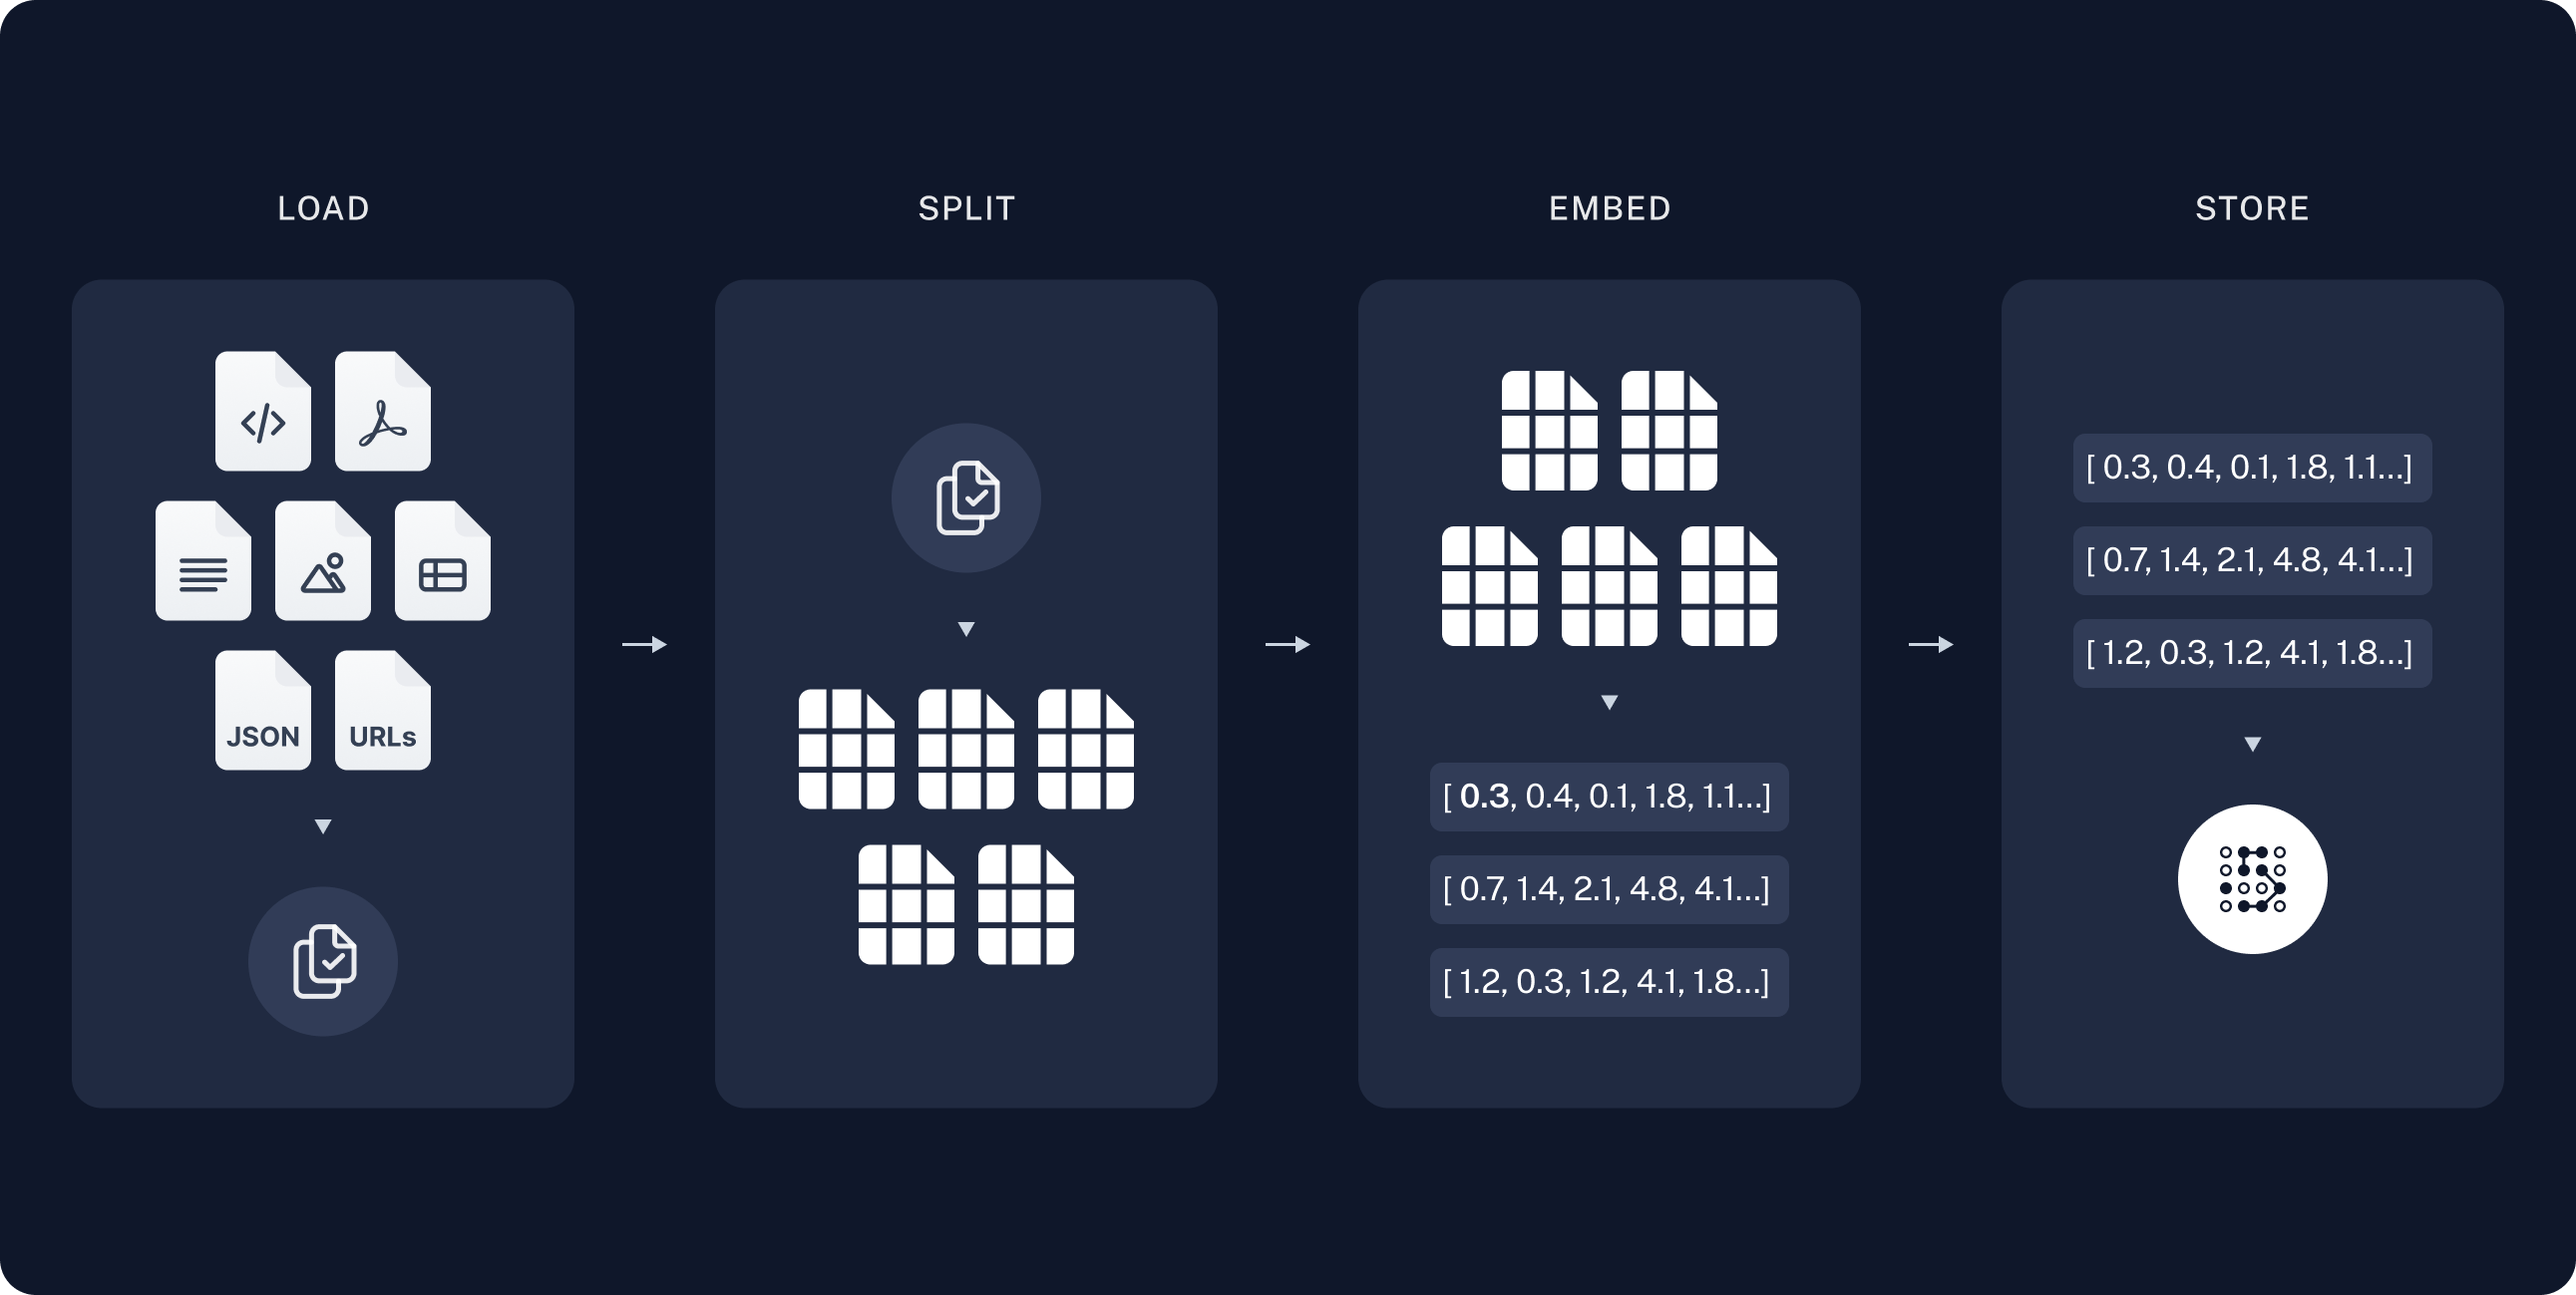

## Retrieval and Generation

4. **Retrieve**: Given a user input, relevant splits are retrieved from storage using a Retriever.
5. **Generate**: A ChatModel / LLM produces an answer using a prompt that includes the question and the retrieved data.

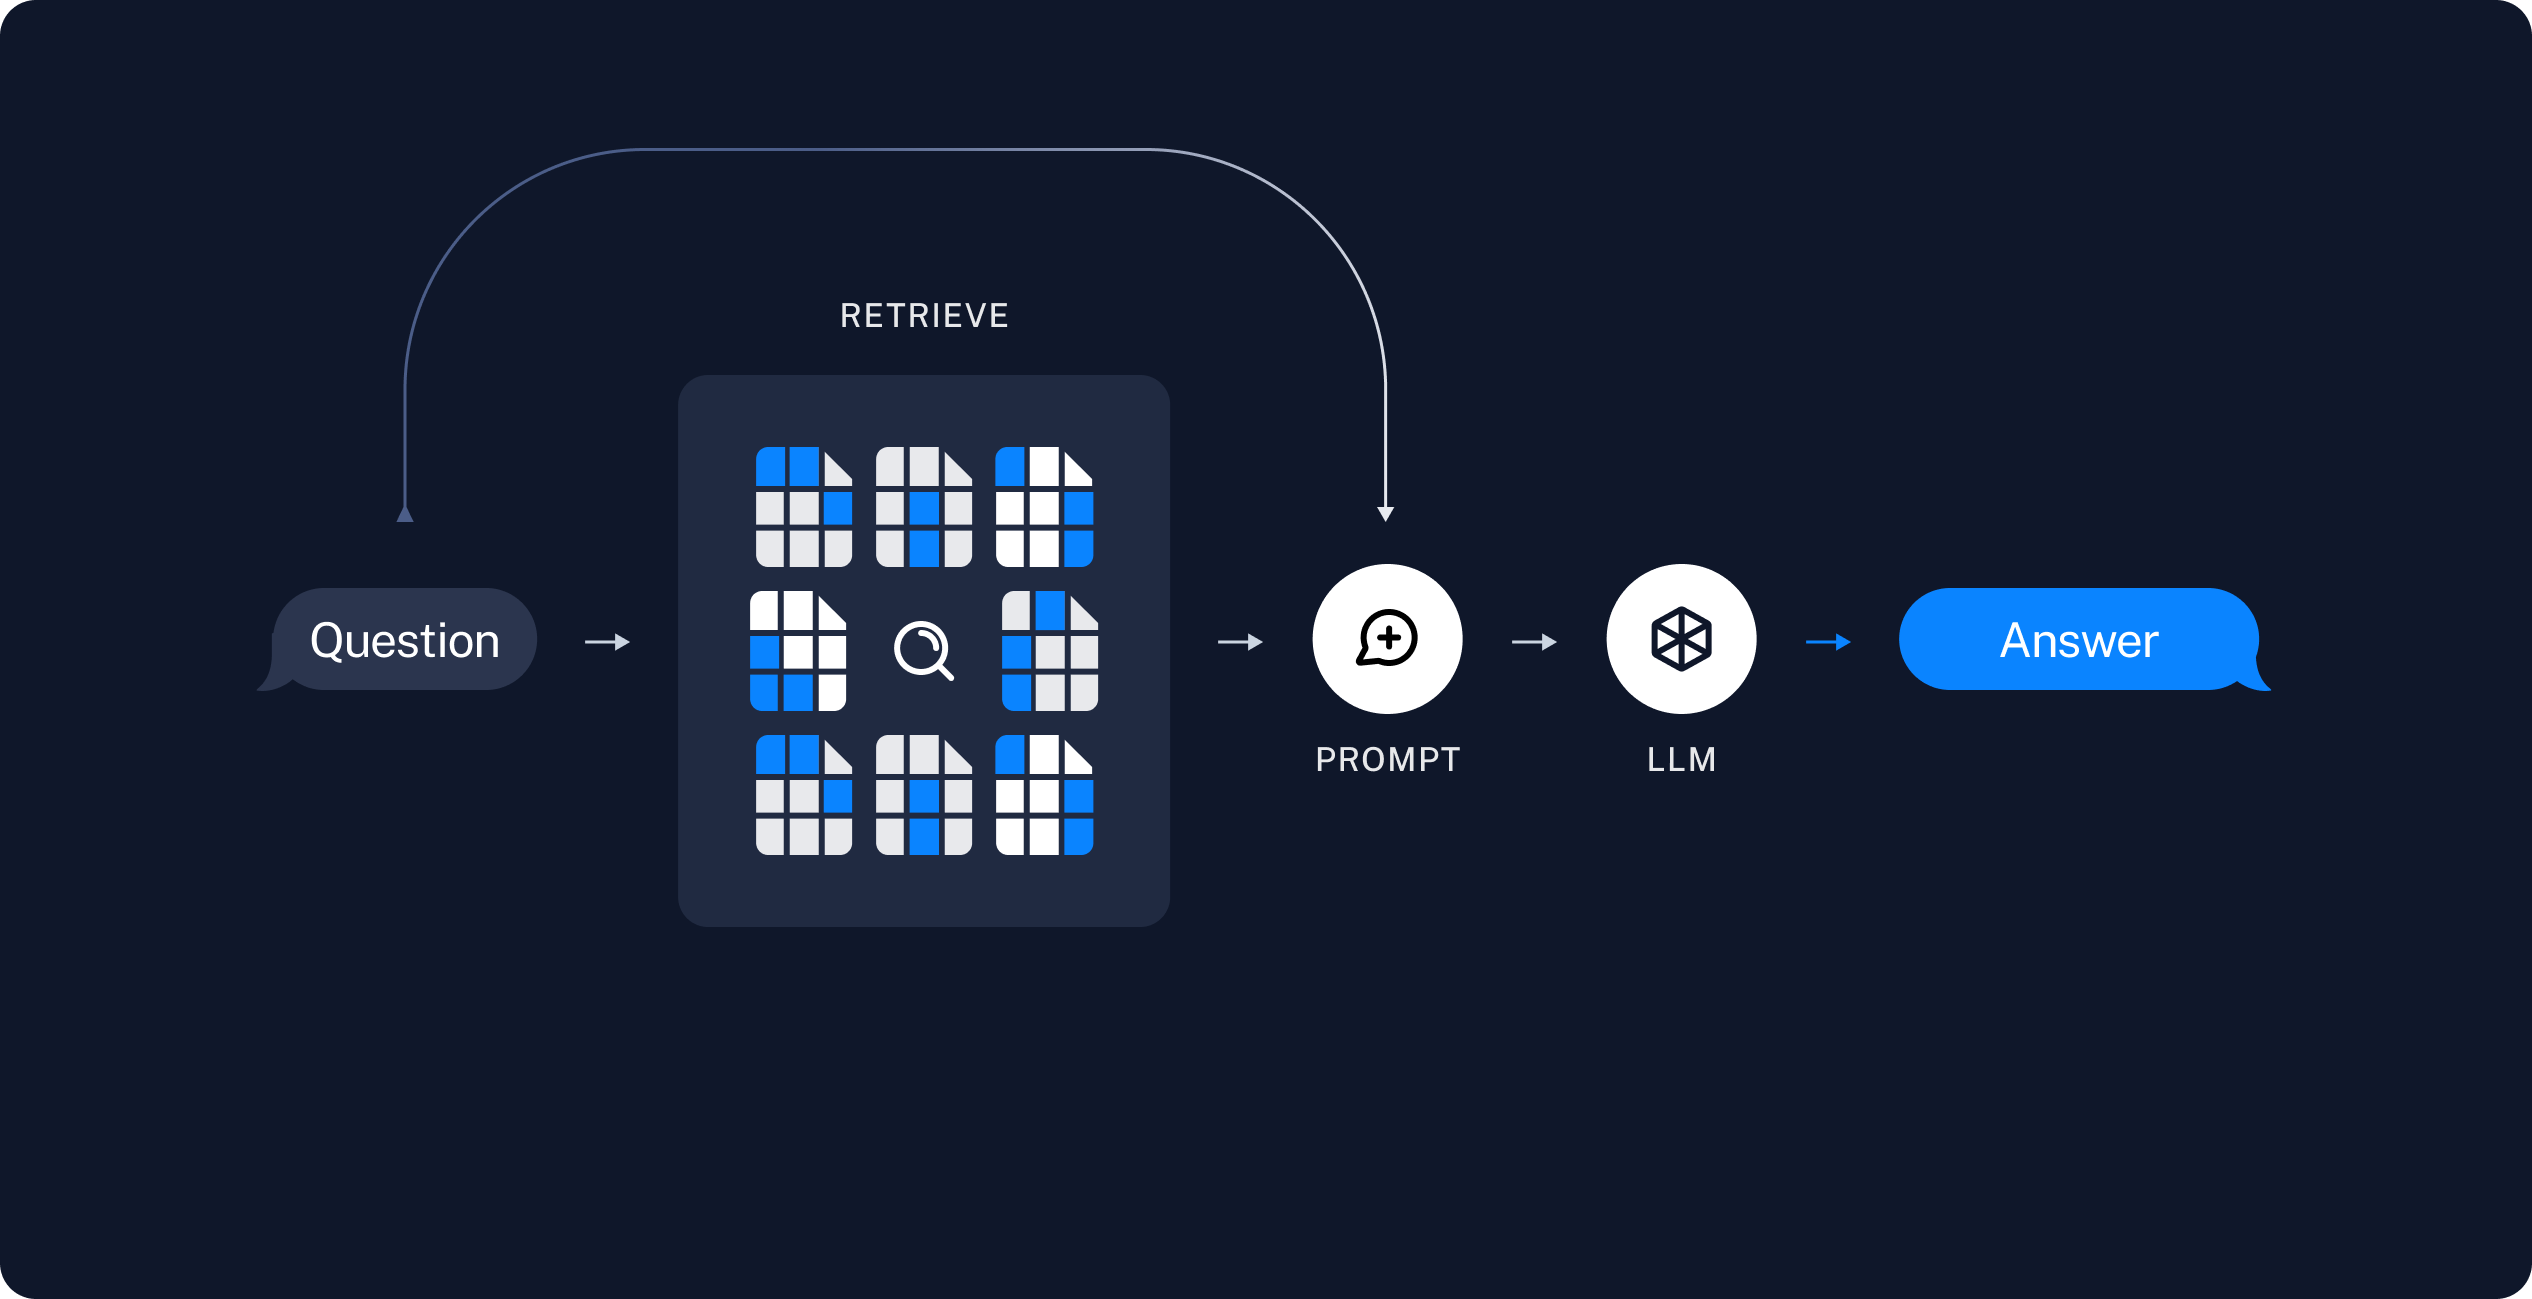


In [1]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass(prompt='LangSmith API Key: ')

In [2]:
os.environ["OPENAI_API_KEY"] = getpass.getpass(prompt='OpenAI API Key: ')

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

In [3]:
# import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import DirectoryLoader, TextLoader, WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = DirectoryLoader("./Whatsapp_Chats", glob="*.txt", loader_cls=TextLoader)
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

In [7]:
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()

In [20]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context (which are past conversations between Sahil and his contacts on WhatsApp) to reply to the message at the end as Sahil.
Answer based on who is sending the message and Sahil's most recent chat history with that person.
The name of the person sending the message will be shown at the beginning of the message.
If you don't know the person, just say that you don't have their number saved, don't try to make up a random reply for a stranger.
Use three sentences maximum and keep the answer as close to how Sahil replies as possible.
Always use and emoji at the end of the answer.

{context}

Message: {messageIn}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "messageIn": RunnablePassthrough()}
    | custom_rag_prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("Shubham: Where are you bro?")

'Hey Shubham! All good. Just chilling in India. 😅👍'